<img src="../Images/DSC_Logo.png" style="width: 400px;">

# Seawater pH dataset

![sea](../Images/sea.jpg)

*Image modified from Renan Brun, Pixabay*

The dataset contains measured pH data and environmental factors such as temperature, salinity, and dissolved oxygen in the Bay of Palma. By training an LSTM model to predict pH and fill data gaps, the study extends pH time series beyond periods covered by direct measurements. 

**Original dataset and code:** https://github.com/agimenezromero/Coastal-pH-variability-reconstructed-through-neural-networks-the-coastal-Balearic-Sea-case-study

**Related publication:** Flecha, S., Giménez-Romero, À., Tintoré, J., Pérez, F. F., Alou-Font, E., Matías, M. A., and Hendriks, I. E.: pH trends and seasonal cycle in the coastal Balearic Sea reconstructed through machine learning, Scientific Reports, 12, 12956, doi:10.1038/s41598-022-17253-5,     2022.

Original data and code were modified for this notebook. The analyses presented here may not align with those published.

In [1]:
pip install statsmodels seaborn scikit-learn tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 83.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 52.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 67.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.9 MB/s eta 0:00:00
   ━━━━

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress FutureWarnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [3]:
seawater_pH = pd.read_csv('../Datasets/seawater_pH.csv', index_col=0)

## **Exercise 1: Multivariate Time Series Analysis**

## 1. Characteristics of Each Time Series

In [4]:
seawater_pH.head()

,Time,Temperature,Salinity,Oxygen,PH
0,2012-05-05,NaN,NaN,249.503668,NaN
1,2012-05-06,NaN,NaN,245.551439,NaN
2,2012-05-07,NaN,NaN,246.486125,NaN
3,2012-05-08,NaN,NaN,245.992856,NaN
4,2012-05-09,NaN,NaN,243.424692,NaN


**Exercise:** Print summary statistics of the dataset. Are the values reasonable from your experience? How many (less) values does the pH time series has compared to the other variables?

In [5]:
seawater_pH.describe()

,Temperature,Salinity,Oxygen,PH
count,2395.000000,2379.000000,1869.000000,587.000000
mean,21.185704,37.559730,245.234332,8.055483
std,4.720070,0.304512,34.765637,0.055880
min,9.815714,36.506500,151.620700,7.934175
25%,16.409583,37.329938,219.009854,8.003404
50%,21.603750,37.518500,242.968300,8.054422
75%,25.776667,37.781148,262.998087,8.108830
max,29.028333,38.303375,350.194519,8.142092


Converting the 'Time' column to `datetime` format:

In [6]:
seawater_pH["Time"] = pd.to_datetime(seawater_pH["Time"])

Plotting all time series in the dataset:

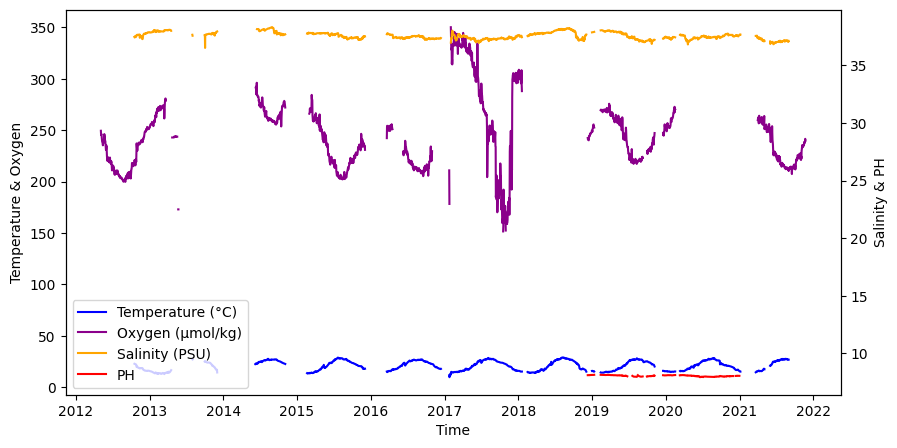

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Temperature and Oxygen on primary y-axis
ax1.plot(seawater_pH['Time'], seawater_pH['Temperature'], 'b-', label='Temperature (°C)')
ax1.plot(seawater_pH['Time'], seawater_pH['Oxygen'], '-', color='#8B008B', label='Oxygen (µmol/kg)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature & Oxygen', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for Salinity and pH
ax2 = ax1.twinx()
ax2.plot(seawater_pH['Time'], seawater_pH['Salinity'], 'orange', label='Salinity (PSU)')
ax2.plot(seawater_pH['Time'], seawater_pH['PH'], 'red', label='PH')
ax2.set_ylabel('Salinity & PH', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')

plt.show()

## 2. Correlation and Cross-Correlation Analysis

## 2.1 Correlation

**Exercise:** Calculate the Pearson correaltion between all the variables in the dataset and plot the heatmap (using `seaborn` library). Identify which variables exhibit the strongest linear correlation with pH values, and investigate the nature of the relationships between these influential variables and pH.

In [8]:
import seaborn as sns

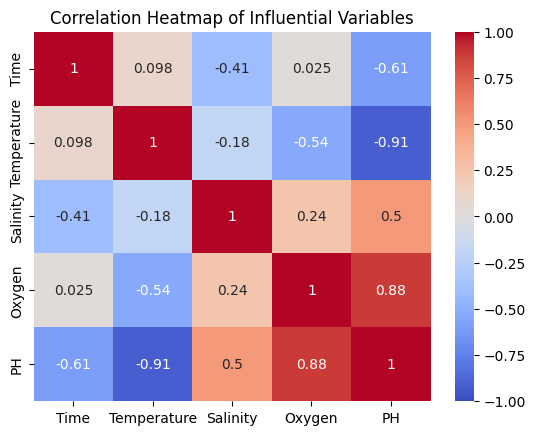

In [9]:
correlation_matrix = seawater_pH.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Influential Variables')
plt.show()

In the heatmap, pH shows the following correlations with other variables:

- Strong negative correlation with Temperature (-0.91): As temperature rises, pH drops significantly.
- Moderate positive correlation with Salinity (0.5): As salinity increases, pH also increases.
- Strong positive correlation with Oxygen (0.88): Higher oxygen levels are linked to higher pH.

These trends make sense. For instance, temperature often affects pH because warmer water holds less CO2, leading to lower pH. Oxygen and pH often rise together in areas of photosynthesis (more oxygen, higher pH).

## 2.2 Cross-correlation

To investigate cross-correlation between pH and the influential variables we first need to remove data with missing pH values. Since data gaps impact the cross-correlation we want to avoid gaps as much as possible and hence define shared time periods for analyzing the cross-correlation individually for each time series pair.

In [10]:
pH_Oxygen = seawater_pH.dropna(subset=['PH','Oxygen'])
pH_Salinity = seawater_pH.dropna(subset=['PH','Salinity'])
pH_Temperature = seawater_pH.dropna(subset=['PH','Temperature'])

**Exercise:** Calculate the cross-correlation over a 200-day period for each time series pair using the `statsmodels` library. Analyze the results to determine the relationships between the variables. What insights can you derive from the cross-correlation analysis?

In [11]:
from statsmodels.tsa.stattools import ccf

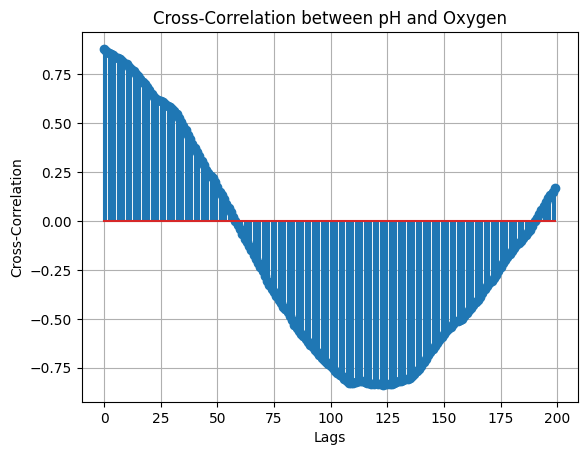

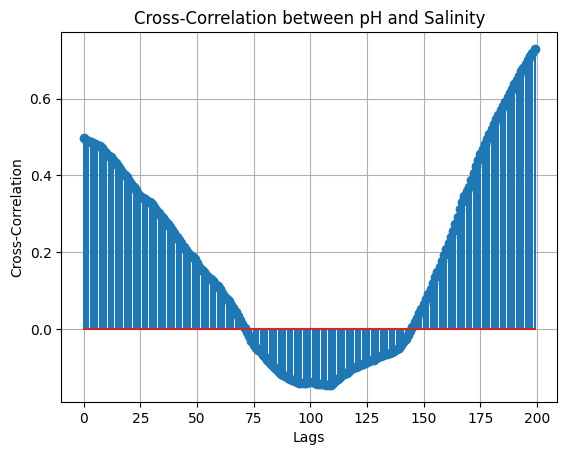

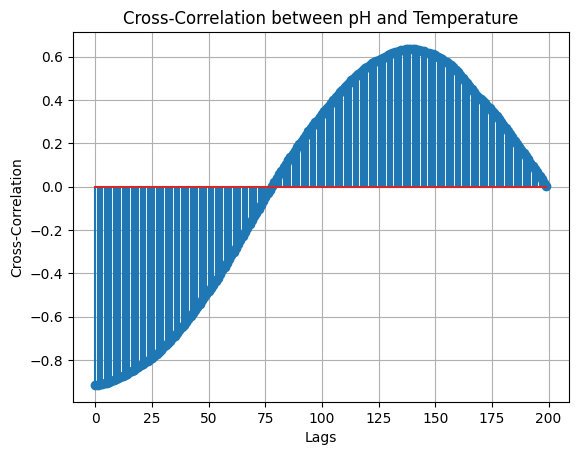

In [12]:
max_lag = 200

# pH_Oxygen:
cross_corr = ccf(pH_Oxygen['PH'], pH_Oxygen['Oxygen'])[:max_lag]
plt.figure()
plt.stem(range(max_lag), cross_corr)
plt.title("Cross-Correlation between pH and Oxygen")
plt.xlabel("Lags")
plt.ylabel("Cross-Correlation")
plt.grid()
plt.show()

# pH_Salinity:
cross_corr = ccf(pH_Salinity['PH'], pH_Salinity['Salinity'])[:max_lag]
plt.figure()
plt.stem(range(max_lag), cross_corr)
plt.title("Cross-Correlation between pH and Salinity")
plt.xlabel("Lags")
plt.ylabel("Cross-Correlation")
plt.grid()
plt.show()

# pH_Temperature:
cross_corr = ccf(pH_Temperature['PH'], pH_Temperature['Temperature'])[:max_lag]
plt.figure()
plt.stem(range(max_lag), cross_corr)
plt.title("Cross-Correlation between pH and Temperature")
plt.xlabel("Lags")
plt.ylabel("Cross-Correlation")
plt.grid()
plt.show()

The cross-correlation fluctuates significantly (from nearly 1 to nearly -1) suggesting that there are times in the year when pH and the influential variables are highly positively correlated, and other times when they are highly negatively correlated. They seem to be well suited for predicting pH values over time. 

## **Exercise 2: Time Series Pre-processing**

## 2. Outlier Detection

In [13]:
# 'PH' is the column of interest
data_values = seawater_pH['PH']

# Assume 'PH' is the column of interest and drop rows with NaN values for DBSCAN
data_values_DBSCAN = data_values.dropna()

**Exercise:** As part of the preprocessing for modeling, outliers/anomalies in the pH time series were detected and manually removed. However, we want to test some outlier removal techniques and see how well we can detect what the authors identified as outliers/anomalies. 

Apply the Z-Score and Moving Average methods on 'data_values' for detecting outliers.

In the following we plot what the authors identified as outliers/anomalies.

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628.]),
 [Text(17897.0, 0, '2019-01'),
  Text(17987.0, 0, '2019-04'),
  Text(18078.0, 0, '2019-07'),
  Text(18170.0, 0, '2019-10'),
  Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01')])

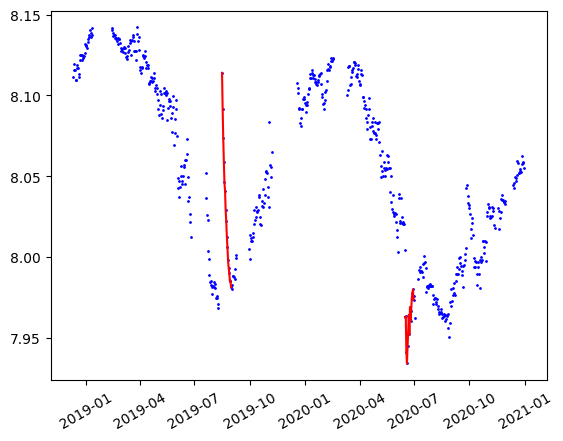

In [14]:
plt.scatter(seawater_pH["Time"], seawater_pH["PH"], s=1, c='b')
plt.plot(seawater_pH["Time"][(seawater_pH["Time"] > datetime(2019, 8, 15)) & (seawater_pH["Time"] < datetime(2019, 9, 1))], 
         seawater_pH["PH"][(seawater_pH["Time"] > datetime(2019, 8, 15)) & (seawater_pH["Time"] < datetime(2019, 9, 1))],
         color='r')
plt.plot(seawater_pH["Time"][(seawater_pH["Time"] > datetime(2020, 6, 15)) & (seawater_pH["Time"] < datetime(2020, 7, 1))], 
         seawater_pH["PH"][(seawater_pH["Time"] > datetime(2020, 6, 15)) & (seawater_pH["Time"] < datetime(2020, 7, 1))],
         color='r')
plt.xticks(rotation=30)

We remove the identified values from the dataset and plot the final pH time series for the prediction task:

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628.]),
 [Text(17897.0, 0, '2019-01'),
  Text(17987.0, 0, '2019-04'),
  Text(18078.0, 0, '2019-07'),
  Text(18170.0, 0, '2019-10'),
  Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01')])

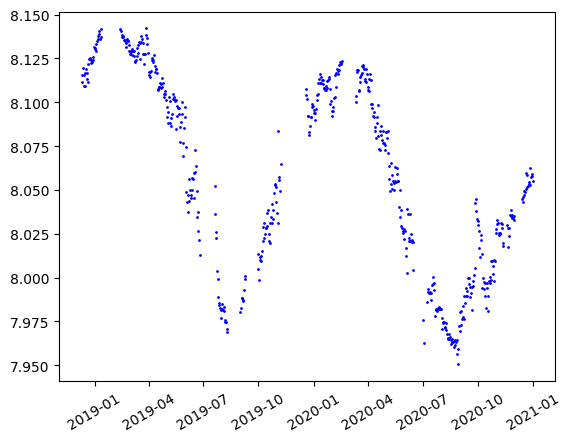

In [15]:
df = seawater_pH.drop(seawater_pH[(seawater_pH["Time"] > datetime(2019, 8, 15)) & (seawater_pH["Time"] < datetime(2019, 9, 1))].index)
df = df.drop(df[(df["Time"] > datetime(2020, 6, 15)) & (df["Time"] < datetime(2020, 7, 1))].index)
plt.scatter(df["Time"], df["PH"], s=1, c='b')
plt.xticks(rotation=30)

## 3. Data Scaling

In the published code, the authors preselected data points where oxygen measurements are available prior to scaling. This approach prevents scaling the temperature and salinity time series on large datasets that will not be included in either the model fitting or the reconstruction task. This is particularly important given the limited availability of oxygen data compared to the other variables (compare the data availability for these time series plotted above).

In [16]:
data = df[df["Oxygen"].astype('str') != 'nan'][["Temperature", "Oxygen", "Salinity", "PH"]].values

**Exercise:** In their study, the authors used min-max normalization to scale the features (temperature, salinity, oxygen) and the pH values for better model fitting. It’s important to be careful when scaling the entire dataset in prediction tasks, because it can lead to data leakage and affect how well the model performs on new data. However, since this study is focused on reconstructing past pH values rather than predicting future ones, scaling the full dataset can be less of a concern. The model learns from historical data to estimate missing pH values, so using all available data helps improve accuracy. 

To implement this, use the `sklearn` `MinMaxScaler` to scale the dataset and name the scaled dataset 'data_n'. Keep the scaler for later.

Note: The time series in this dataset contain missing values. Many common scaling methods, such as Min-Max scaling or standardization (Z-transformation), require a complete set of values. However, some libraries, like Scikit-learn in Python, have parameters to ignore NaN values. If you choose this option, only the available (non-NaN) values will be used to calculate the scaling.

**Exercise:** Print the minimum and maximum of the scaled data to access the success of the scaling. Check out the `np.nanmin` function for this. 

In [ ]:
import numpy as np


## **Exercise 3: Time Series Prediction**

## 4. Sequence Generation for Model Training

Extraction of sequences used for training and testing the model:

In [ ]:
window_size = 6
n_features = data.shape[-1] - 1

X = np.zeros((len(data_n) - window_size, window_size, n_features))
Y = np.zeros(len(data_n) - window_size)
for i in range(len(data_n) - window_size):
    X[i] = data_n[i:window_size + i, 0:n_features]
    Y[i] = data_n[window_size + i, -1]

idxs = [i for i in range(len(X)) if np.any(np.isnan(X[i])) or np.isnan(Y[i])]
X_new = np.delete(X, idxs, axis=0)
Y_new = np.delete(Y, idxs, axis=0)

**Exercise:** In the study, the dataset subset containing also pH measurements was split into two parts. The purpose of the larger set (90% of the samples in 'X_new' and 'Y_new') was to teach the model to reconstruct pH values based on the features of temperature, oxygen, and salinity. The smaller set (10% of the samples in 'X_new' and 'Y_new') was used to evaluate the model’s performance and fine-tune its settings (adapt parameters) for better accuracy. 

Define a variable 'test_size' with the appropriate value to be used in the `train_test_split` function. Next, split the data into 'X_train'/'Y_train' and 'X_test'/'Y_test' and investigate the shape of the two datasets.

**Exercise:** For the reconstruction task, we now create dataset that will be used for model predictions. Create a Python list named 'features_list' that includes the names of the features utilized in this study to predict pH values. Then continue with the next code block.

In [ ]:
data_new = df[features_list].values
scaled_new = scaler.min_[:n_features] + data_new * scaler.scale_[:n_features]
X_to_predict = np.zeros((len(scaled_new) - window_size, window_size, n_features))
for i in range(len(scaled_new) - window_size):
    X_to_predict[i] = scaled_new[i:window_size + i, 0:n_features]

All datasets required for training and predicting with the LSTM model in this study have now been prepared. The following section will define the LSTM model, fit the model on available pH values and run predictions using the prepared datasets.

## 5. LSTM Model

### Build Model:

In [ ]:
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from time import time as time 

class PrintCrossPoint(Callback):
    def __init__(self):
        self.epoch_cross = ""
        self.epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        logs = logs or {}
        current_train_loss = logs.get("loss")
        current_val_loss = logs.get("val_loss")
        if current_val_loss < current_train_loss:
            if self.epoch_cross == "":
                self.epoch_cross = self.epoch

    def on_train_end(self, logs=None):
        print("Validation loss lower than training loss from epoch %s!" % self.epoch_cross)

class StopCrossPoint(Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        logs = logs or {}
        current_train_loss = logs.get("loss")
        current_val_loss = logs.get("val_loss")
        if current_val_loss < current_train_loss:
            print("Training loss higher than validation loss from epoch %s!" % self.epoch)
            self.model.stop_training = True

callback_1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, min_delta=0.00001)
callback_2 = StopCrossPoint()   

# Design network
model_LSTM = Sequential()
model_LSTM.add(LSTM(3, input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='mse', optimizer='adam')

### Fit model:

In [ ]:
# Fit network
history_LSTM = model_LSTM.fit(
    X_train,
    Y_train,
    epochs=500,
    steps_per_epoch=10,
    batch_size=32,
    validation_data=(X_test, Y_test),
    verbose=0,
    shuffle=False,
    callbacks=[callback_1, callback_2]
)

# Run metrics
t0 = time()
time_elapsed_LSTM = time() - t0
epochs_used_LSTM = len(history_LSTM.history['loss'])
print("Finished in", time_elapsed_LSTM, "s using", epochs_used_LSTM, "epochs")

# Losses in percent
final_train_loss_LSTM = (history_LSTM.history['loss'][-1] * 100)
final_val_loss_LSTM = (history_LSTM.history['val_loss'][-1] * 100)
init_train_loss_LSTM = (history_LSTM.history['loss'][0] * 100)

### Predict model:

**Exercise:** Use the model to predict and reconstruct pH values, and assign the predicted output values to the variable 'y_pred_LSTM'.

Finally, we rescale `y_pred_LSTM` to return it to the original scale of the pH values. 

Note: Although `scaler.inverse_transform` can be used for this purpose, it's important to note that the `MinMaxScaler` was fitted on the multivariate original data, which included four features: Temperature, Salinity, Oxygen, and pH. As a result, the method expects an input with four columns. When attempting to pass `y_pred_LSTM`, the shapes do not match, leading to a shape mismatch error. Therefore, we directly apply the scaling formula to convert the normalized pH predictions back to their original scale, using the parameters from the scaler that correspond specifically to the pH values.

In [ ]:
y_pred_noscale_LSTM = (y_pred_LSTM - scaler.min_[-1]) / scaler.scale_[-1]

## 6. Linear Regression

Linear regression was used in the study to examine the long-term trends and seasonal changes of pH levels in the coastal Balearic Sea based on the reconstructed pH data obtained, with trends calculated using yearly intervals. 

In [ ]:
# Assign predictions to the appropriate locations in y_pred_noscale_LSTM
y_pred_noscale_LSTM[:, 0][df["PH"][window_size:].astype('str') != 'nan'] = df["PH"][window_size:][df["PH"][window_size:].astype('str') != 'nan'].values

# Calculating time differences in years
time_delta = df["Time"][window_size:] - df["Time"][window_size]
time_years = np.array([(item / np.timedelta64(1, 'm')) / (60 * 24 * 365) for item in time_delta])

# Preparing data for linear regression
Y_TREND = y_pred_noscale_LSTM[y_pred_noscale_LSTM.astype('str') != 'nan']
X_TREND = time_years[y_pred_noscale_LSTM[:, 0].astype('str') != 'nan']

**Exercise:** Y_TREND contains the reconstructed pH values and X_TREND containes the corresponding time in yearly intervals. Fit a linear regression model to the reconstructed pH time series data using the `statsmodels` library. What is the slope of the trend?

## 7. Plots

In the following, we visualize the model results along with the pH reconstructions. Please note that the figure in the publication represent a different neural network model, which has demonstrated slightly better accuracy for this dataset.

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Loss functions
plt.subplot(2, 2, 1)
plt.plot(history_LSTM.history['loss'], label='Train loss', lw=3, c='black')
plt.plot(history_LSTM.history['val_loss'], label='Validation loss', lw=3, c='grey')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize=30, labelpad=10)
plt.ylabel("Loss (MSE)", fontsize=30, labelpad=10)
plt.text(epochs_used_LSTM * 0.5, init_train_loss_LSTM * 0.006,
         "Final train loss: %.2f%%" % final_train_loss_LSTM, fontsize=16)
plt.text(epochs_used_LSTM * 0.5, init_train_loss_LSTM * 0.005,
         "Final val loss: %.2f%%" % final_val_loss_LSTM, fontsize=16)
plt.legend(fontsize=20)

# For evaluating model fit: Receive prediction of the entire dataset (training + testing) to compare with observations
yhat_LSTM = model_LSTM.predict(X_new) 

# Subplot 2: Predicted pH time series in the training process (orange) and observation (blue)
plt.subplot(2, 2, 2)
plt.scatter(yhat_LSTM, Y_new, s=20, c='grey')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='black', lw=3)
plt.xlabel("Predicted values", fontsize=30, labelpad=10)
plt.ylabel("True values", fontsize=30, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Subplot 3: Predicted vs. observed pH values
plt.subplot(2, 2, 3)
plt.plot(Y_new, lw=3, c='b', label='Measured')  # Observed values in blue
plt.plot(yhat_LSTM, lw=3, c='orange', label='Predicted')  # Predicted values in orange
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Training data sequence", fontsize=30, labelpad=10)
plt.ylabel(r"pH$_\mathrm{T}$ (scaled)", fontsize=30, labelpad=10)

# Subplot 4
plt.subplot(2, 2, 4)
df_to_save = df.loc[:, ("Time", "PH")]
df_to_save["DataType"] = ["" for i in range(len(df_to_save))]

for i in range(6, len(df_to_save[6:])):
    if np.isnan(df_to_save["PH"].iloc[i]):
        df_to_save["PH"].iloc[i] = y_pred_noscale_LSTM[i][0]
        df_to_save["DataType"].iloc[i] = "Prediction"
    else:
        df_to_save["DataType"].iloc[i] = "Observation"

plt.scatter(df_to_save["Time"][df_to_save["DataType"] == "Observation"], 
            df_to_save["PH"][df_to_save["DataType"] == "Observation"], s=1, lw=3, c='b', label='Measured')
plt.scatter(df_to_save["Time"][df_to_save["DataType"] == "Prediction"], 
            df_to_save["PH"][df_to_save["DataType"] == "Prediction"], s=1, lw=3, c='r', label='Reconstructed')
time_delta_plot = df["Time"] - df["Time"][0]
time_years_plot = np.array([(item / np.timedelta64(1, 'm')) / (60 * 24 * 365) for item in time_delta_plot])
plt.plot(df_to_save["Time"], slope_LSTM * time_years_plot + intercept_LSTM, color='k', lw=3, 
         label=r'y=%.4fx + %.4f' % (slope_LSTM, intercept_LSTM))
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)
plt.xlabel("Time [years]", fontsize=30)
plt.ylabel(r"pH$_\mathrm{T}$", fontsize=30)

# Custom legend without markers
plt.figtext(0.3, 0, 'Measured', fontsize=30, ha='center', color='blue')  # Centered below the plots
plt.figtext(0.5, 0, 'Predicted', fontsize=30, ha='center', color='orange')  # Centered below the plots
plt.figtext(0.7, 0, 'Reconstructed', fontsize=30, ha='center', color='red')  # Centered below the plots

# Show the plot
plt.subplots_adjust(hspace=0.3, wspace=0.3, bottom=0.15)
plt.tight_layout()
plt.show()